# Image classification using Conv Nets.
### 1) Using image files on disk, instead of in-memory data.
### This example uses ImageGenerators instead of tf.data. Tf.data is faster, but the ImageGenerators seems easier to implement


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import random

print(tf.version.GIT_VERSION, tf.version.VERSION)
print("GPU available: ", tf.test.is_gpu_available())
# print("GPU available: ", tf.config.list_physical_devices('GPU'))


W0303 14:50:50.883476  2500 deprecation.py:323] From <ipython-input-1-4281998b60e9>:9: is_gpu_available (from tensorflow.python.framework.test_util) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


v2.1.0-rc2-17-ge5bf8de410 2.1.0
GPU available:  True


## Load Data

The dataset is a simple cats and dogs dataset. The data folder has two subfolders - train and validation, with each
having two subfolders that represent the dog and cats data.

For other dataset, make sure the dataset has training examples separated by folders.

In [23]:

_URL =  'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# #Provide absolute path otherwise data is stored in ~/.keras/datasets/ with given fname  
# download_data_loc = os.path.join(os.path.abspath(os.path.pardir),'data\cats_and_dogs.zip')
# print("Downloading data to the following location: {}".format(download_data_loc))
# path_to_zip = tf.keras.utils.get_file(download_data_loc,origin=_URL,extract=True, archive_format='zip')
# PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')


print(path_to_zip)
print(PATH)


C:\Users\abhat\.keras\datasets\cats_and_dogs.zip
C:\Users\abhat\.keras\datasets\cats_and_dogs_filtered


### Create variables for training and validation

In [3]:
train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')

train_cats_dir = os.path.join(train_dir,'cats')
train_dogs_dir = os.path.join(train_dir,'dogs')
validation_cats_dir = os.path.join(validation_dir,'cats')
validation_dogs_dir = os.path.join(validation_dir,'dogs')

print(train_cats_dir)
print(train_dogs_dir)
print(validation_cats_dir)
print(validation_dogs_dir)


C:\Users\abhat\.keras\datasets\cats_and_dogs_filtered\train\cats
C:\Users\abhat\.keras\datasets\cats_and_dogs_filtered\train\dogs
C:\Users\abhat\.keras\datasets\cats_and_dogs_filtered\validation\cats
C:\Users\abhat\.keras\datasets\cats_and_dogs_filtered\validation\dogs


### Understanding the data 

In [4]:
# How many images are available?
num_train_cats = len(os.listdir(train_cats_dir))
num_train_dogs = len(os.listdir(train_dogs_dir))
num_validation_cats = len(os.listdir(validation_cats_dir))
num_validation_dogs = len(os.listdir(validation_dogs_dir))

total_train = num_train_cats + num_train_dogs
total_validation = num_validation_cats + num_validation_dogs

print("#Training images for cats: {}".format(num_train_cats))
print("#Training images for dogs: {}".format(num_train_dogs))
print("#Validation images for cats: {}".format(num_validation_cats))
print("#Validation images for dogs: {}".format(num_validation_dogs))
print("#Total training images {}".format(total_train))
print("#Total validation images {}".format(total_validation))

# Another method of getting the length of files
# import glob
# import pathlib
# image_count = len(list(pathlib.Path(train_dir).glob('*/*.jpg')))
# print(image_count)



#Training images for cats: 1000
#Training images for dogs: 1000
#Validation images for cats: 500
#Validation images for dogs: 500
#Total training images 2000
#Total validation images 1000


Showing training data for class dogs on grid on rows=4, and cols=3


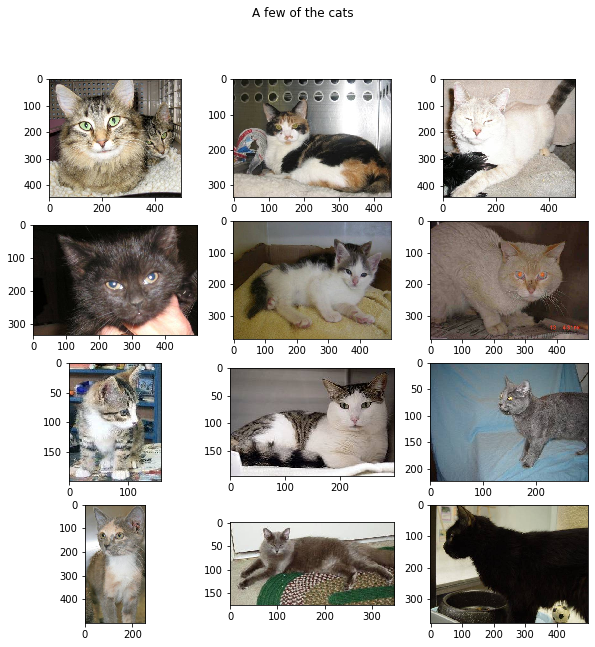

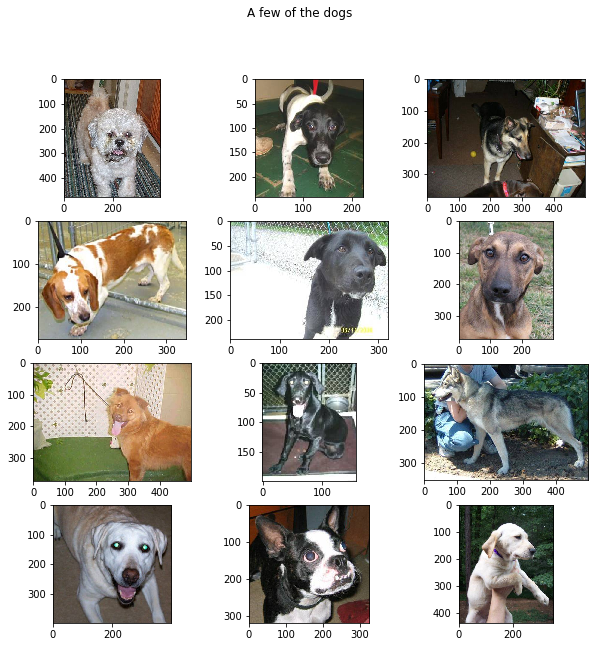

In [5]:
# Show a few images
num_show_samples = 12
idx_show = random.sample(range(num_train_dogs),num_show_samples)

rows = 4
cols = int(np.ceil(num_show_samples/rows))

print("Showing training data for class dogs on grid on rows={}, and cols={}".format(rows,cols))

# print(idx_show)
# os.listdir(train_cats_dir)[idx_show[0]]
# train_cats_dir

plt.figure(figsize=(10,10))
plt.suptitle("A few of the cats")
for i in range(num_show_samples):
    fname = os.path.join(train_cats_dir,os.listdir(train_cats_dir)[idx_show[i]])
#     print(fname)    
    ax = plt.subplot(rows,cols,i+1)
    asd = plt.imread(fname)
    plt.imshow(asd)

plt.figure(figsize=(10,10))
plt.suptitle("A few of the dogs")
for i in range(num_show_samples):
    fname = os.path.join(train_dogs_dir,os.listdir(train_dogs_dir)[idx_show[i]])
#     print(fname)    
    ax = plt.subplot(rows,cols,i+1)
    asd = plt.imread(fname)
    plt.imshow(asd)


In [24]:
# Set up additional variables for training purposes

batch_size = 32
steps_per_epoch = total_train // batch_size
validation_steps  = total_validation // batch_size
epochs = 100
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Note: The steps_per_epoch and validation_steps are necessary because ImageGenerator can 
# go on indefinitely with generating the augmented data, so I need to specify when an epoch is complete


## Data preparation

Before feeding to the network, we need to do a few things to the data

1. Read the image from disk
2. Decode content, and convert to proper grid format as per RGB content
3. Convert to floating point tensor. Use 32 bit, instead of 64 bit since that is optimized for tf
4. Rescale tensors from 0 - 255 to 0 - 1
5. Apply additional transforms for data augmentation

In [7]:
#Use the ImageDatGenerator class from tf.keras. This is used for 
# reading images from disk, and preprocessing them into proper tensors
# Further, it also creates batches of data that will be provided to the training
train_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                    rotation_range=40,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    zoom_range= 0.5,
                                                                    horizontal_flip=True)


validation_image_generator =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


#After defining the ImageGenerator, use flow_from_directory method to load images, and specify the batch sizes

train_data_gen = train_image_generator.flow_from_directory(directory = train_dir,
                                                          target_size = (IMG_HEIGHT,IMG_WIDTH),
                                                          batch_size = batch_size,
                                                          shuffle=True,
                                                          class_mode='binary')

val_data_gen = validation_image_generator.flow_from_directory(directory = validation_dir,
                                                          target_size = (IMG_HEIGHT,IMG_WIDTH),
                                                          batch_size = batch_size,
                                                          class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


sample_training_images shape: (32, 150, 150, 3)


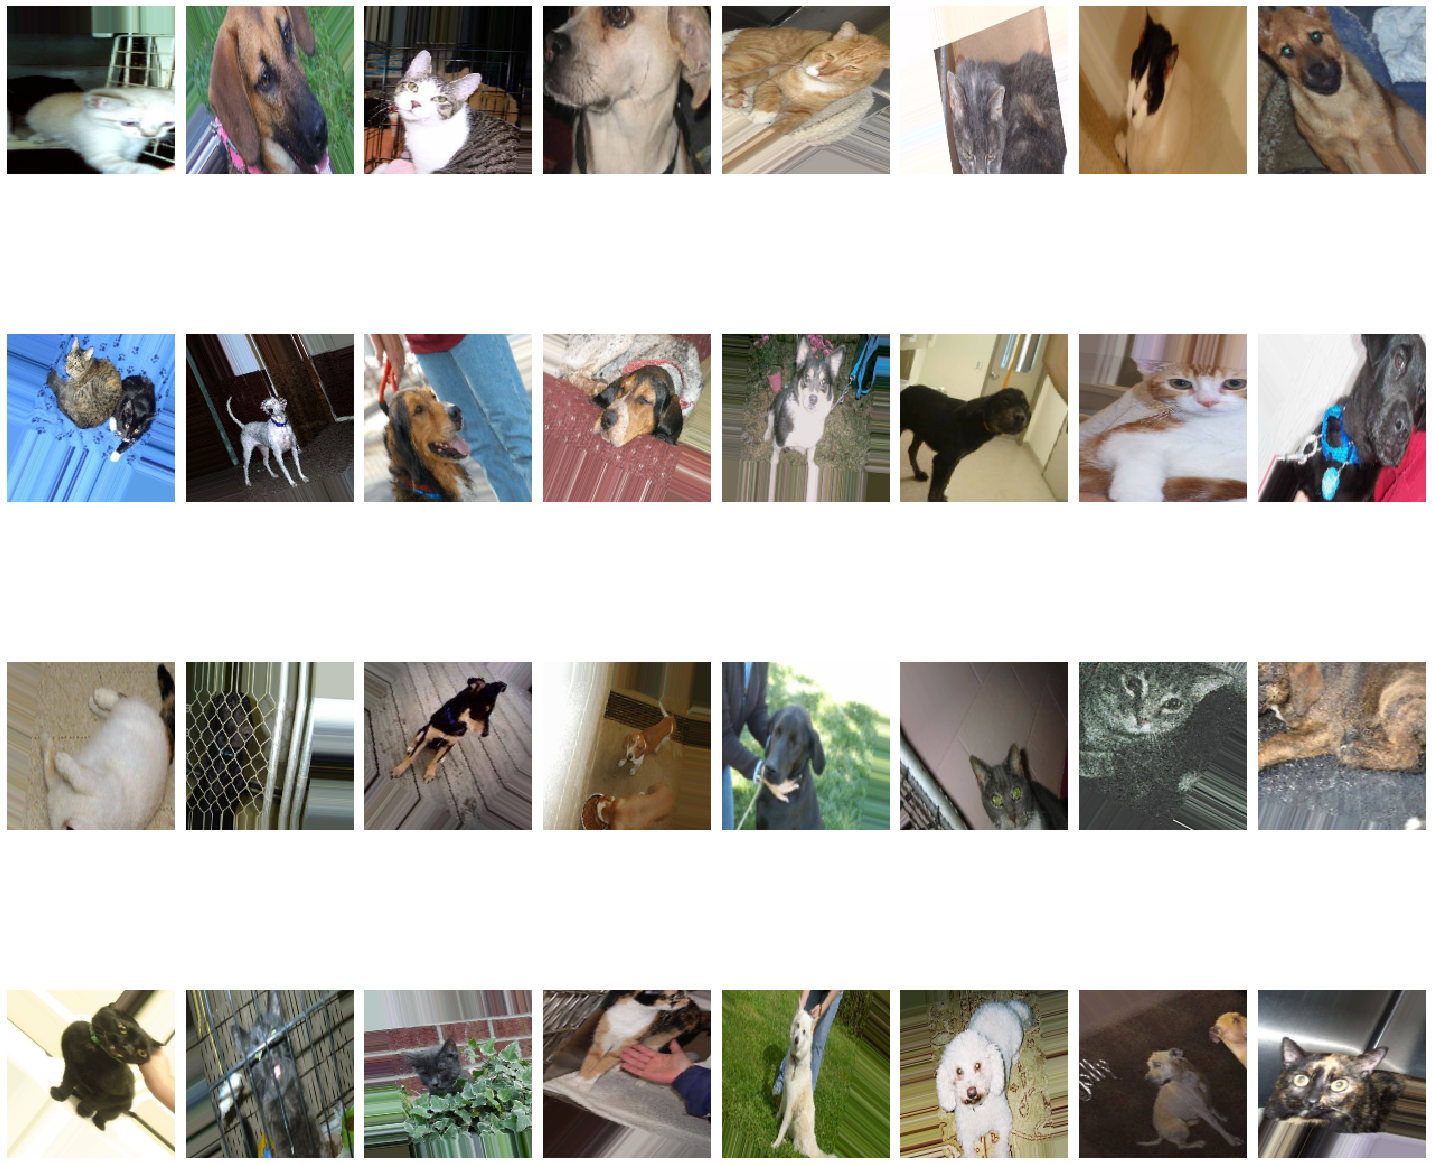

In [8]:
#Visualize the data again, but this time use the data generator for acquiring the images

sample_training_images, sample_training_labels = next(train_data_gen)

print("sample_training_images shape: {}".format(sample_training_images.shape))
# Create a function to plot images given a batch

def plotImages(images_arr,labels_arr):
    rows = 4
    cols = int(np.ceil(images_arr.shape[0] /4))
               
    fig,axes = plt.subplots(rows,cols,figsize=(20,20))
    axes = axes.flatten()
    for img,ax,label in zip(images_arr,axes,labels_arr):
        ax.imshow(img)        
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images,sample_training_labels)


## Create the model

In [9]:
def build_model(dropout=0.2):
    model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
        keras.layers.Conv2D(filters=16, kernel_size=3,padding='same',activation='relu'),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(dropout),
        keras.layers.Conv2D(filters=32, kernel_size=3,padding='same',activation='relu'),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(dropout),
        keras.layers.Conv2D(filters=64, kernel_size=3,padding='same',activation='relu'),
        keras.layers.MaxPool2D(),
        keras.layers.Dropout(dropout),
        keras.layers.Flatten(),
        keras.layers.Dense(512,activation='relu'),
#         keras.layers.Dense(1,activation='sigmoid', name='output')
        keras.layers.Dense(1, name='output')
    ], name='cnn_dog_cat_classifier')
    
    return model

model = build_model()

model.summary()
        


Model: "cnn_dog_cat_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 

In [10]:
#Compile the model
model.compile(optimizer = 'adam',
             loss = keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])




### Create callbacks

In [11]:

model_folder_name = "cnn_dog_cat_classifier"
model_name = model_folder_name + ".h5"


#ModelCheckpoint - Save only the best model
save_model_filepath = os.path.join(os.path.abspath(os.pardir),"models",model_folder_name,model_name)

print("ModelCheckpoint Callback saves the model in: {}".format(save_model_filepath))

checkpoint_cb = keras.callbacks.ModelCheckpoint(save_model_filepath,
                                               save_best_only=True)

# Early stopping.
# ModelCheckpoint will save best, but wont stop training, which might go on for a long time and consume resources.
# Early stoppoing callback helps with this
# early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                                      patience=10,
#                                                      restore_best_weights=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

#Create a custom callback if needed. For example, display the ratio of validation loss / training_loss to detect overfitting
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        print("\n Custom Callback - Epoch: {}, val/train loss ratio: {:.2f}".format(epoch, logs["val_loss"] / logs["loss"]))

#Instance of the custom callback
print_ratio_cb = PrintValTrainRatioCallback()

#Tensorboard callback

#Note:
#For windows, forward and back slahses are painful to get right for the tensorboard usage.
# What works is that create a windows path, and replace the \ with \\

#Save data in models folder.
root_logdir = os.path.join(os.pardir, "models", model_folder_name, "tensorboard", "my_logs")
print("Tensorboard parent logs folder: {}".format(root_logdir))

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir()
print("Current logdir: {}".format(run_logdir))

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)



ModelCheckpoint Callback saves the model in: C:\Users\abhat\research\Tensorflow_2.0_tutorials\models\cnn_dog_cat_classifier\cnn_dog_cat_classifier.h5
Tensorboard parent logs folder: ..\models\cnn_dog_cat_classifier\tensorboard\my_logs
Current logdir: ..\models\cnn_dog_cat_classifier\tensorboard\my_logs\run_2020_03_03_14_51_03


In [12]:
# Train the model
history = model.fit_generator(train_data_gen,
                             steps_per_epoch = steps_per_epoch,
                             epochs=epochs,
                             validation_data= val_data_gen,
                             validation_steps = validation_steps,
                             callbacks=[checkpoint_cb,early_stopping_cb, tensorboard_cb])


W0303 14:51:03.430710  2500 deprecation.py:323] From <ipython-input-12-dd3584cb4d97>:7: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0303 14:51:03.633803  2500 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']
W0303 14:51:03.696304  2500 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 62 steps, validate for 31 steps
Epoch 1/100
62/62 [==============================] - 16s 253ms/step - loss: 1.0080 - accuracy: 0.4985 - val_loss: 0.6916 - val_accuracy: 0.5010
Epoch 2/100
62/62 [==============================] - 14s 231ms/step - loss: 0.6877 - accuracy: 0.5005 - val_loss: 0.6813 - val_accuracy: 0.5050
Epoch 3/100
62/62 [==============================] - 15s 234ms/step - loss: 0.6756 - accuracy: 0.5462 - val_loss: 0.6597 - val_accuracy: 0.5544
Epoch 4/100
62/62 [==============================] - 15s 240ms/step - loss: 0.6519 - accuracy: 0.5803 - val_loss: 0.6290 - val_accuracy: 0.6129
Epoch 5/100
62/62 [==============================] - 14s 225ms/step - loss: 0.6371 - accuracy: 0.6032 - val_loss: 0.6326 - val_accuracy: 0.6240
Epoch 6/100
62/62 [==============================] - 14s 226ms/step - loss: 0.6354 - accuracy: 0.6052 - val_loss: 0.6561 - val_accuracy: 0.6240
Epoch 7/100
62/62 [==============================] - 15s 234ms/step - loss: 0.6232 - accuracy:

62/62 [==============================] - 14s 225ms/step - loss: 0.4837 - accuracy: 0.7571 - val_loss: 0.4885 - val_accuracy: 0.7228
Epoch 58/100
62/62 [==============================] - 14s 224ms/step - loss: 0.5031 - accuracy: 0.7439 - val_loss: 0.4836 - val_accuracy: 0.7278
Epoch 59/100
62/62 [==============================] - 14s 226ms/step - loss: 0.4969 - accuracy: 0.7459 - val_loss: 0.4804 - val_accuracy: 0.7530
Epoch 60/100
62/62 [==============================] - 14s 225ms/step - loss: 0.4896 - accuracy: 0.7607 - val_loss: 0.4977 - val_accuracy: 0.7097
Epoch 61/100
62/62 [==============================] - 14s 227ms/step - loss: 0.4824 - accuracy: 0.7449 - val_loss: 0.4774 - val_accuracy: 0.7389
Epoch 62/100
62/62 [==============================] - 14s 225ms/step - loss: 0.4763 - accuracy: 0.7561 - val_loss: 0.4983 - val_accuracy: 0.7077
Epoch 63/100
62/62 [==============================] - 14s 225ms/step - loss: 0.4829 - accuracy: 0.7464 - val_loss: 0.4970 - val_accuracy: 0.737

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


(0, 1)

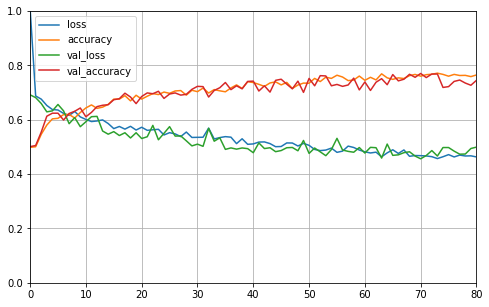

In [13]:
#Visualizing the results

#Plot the history
import pandas as pd

print(history.history.keys())
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1) # Set the vertical range to [0 -1]

# Note that the training and validation accuracy are still improving, 
# so we can probably increase the number of training epochs.  